In [0]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
destinations = pd.read_csv("/content/drive/My Drive/Colab Notebooks/dataset/destinations.csv")
destinations.shape

(62106, 150)

In [0]:
test = pd.read_csv("/content/drive/My Drive/Colab Notebooks/dataset/test.csv")
test.shape

(2528243, 22)

In [0]:
train = pd.read_csv("/content/drive/My Drive/Colab Notebooks/dataset/ds_train.csv")
train.shape

(319954, 27)

In [0]:
train["date_time"] = pd.to_datetime(train["date_time"])
train["year"] = train["date_time"].dt.year
train["month"] = train["date_time"].dt.month

In [0]:
# Obtain new training and testing sets
t1 = train[((train.year == 2013) | ((train.year == 2014) & (train.month < 8)))]
t2 = train[((train.year == 2014) & (train.month >= 8))]

In [0]:
# Make new test set similar to original test set by removing non-booking events
  t2 = t2[t2.is_booking == True]

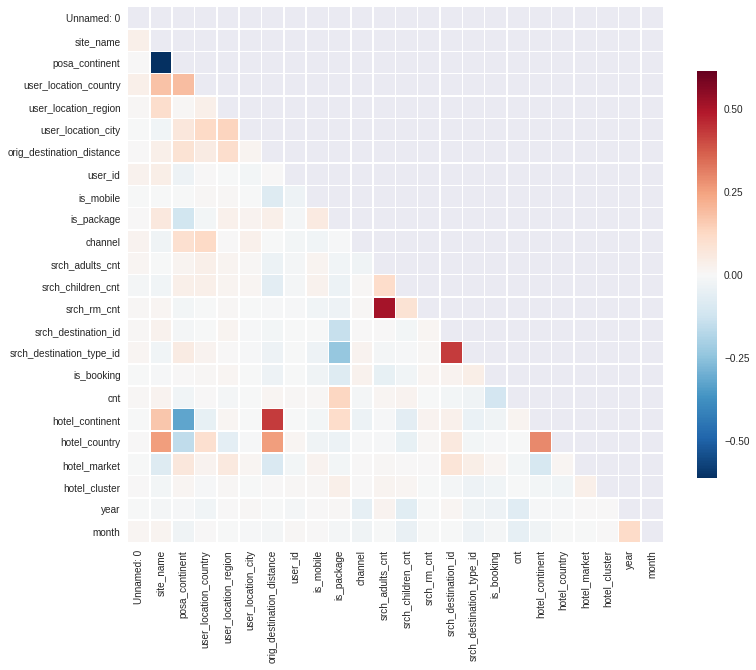

In [0]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
# Check to see if anything correlates to "hotel_cluster"
corr = train.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12, 15))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, vmax=.3, square=True, linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)
plt.show()

As we can see, there is no apparent linear correlation between any of the features and the hotel_cluster. This means that we cannot use techniques like linear or logistic regression on our dataset.

In [0]:
# remove travel agents
unique_users = train.user_id.unique()

train1 = train[train.is_booking != 0]

print(train.shape)
for user in unique_users:
  bookings = len(train1.loc[train1['user_id'] == user])
  if bookings >= 20:
    train = train[train.user_id != user]
  #print(user)
  #print(bookings)
print(train.shape)

(319954, 27)
(295058, 27)


[0.46106252 0.10834396 0.04631931 0.02508247 0.02338353 0.02127211
 0.01691691 0.01515159 0.01439345]


Text(0,0.5,'Pro. Variance Explained')

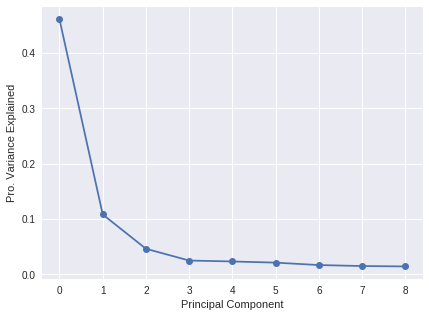

In [0]:
# use PCA to reduce dimensionality
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

plt.rcParams.update({'font.size': 22})

# Use 9 components to show the shape of the PCA curve
pca = PCA(n_components = 9)
dest_small = pca.fit_transform(destinations[["d{0}".format(i + 1) for i in range(149)]])
print(pca.explained_variance_ratio_)

dest_small = pd.DataFrame(dest_small)
dest_small["src_destination_id"] = destinations["srch_destination_id"]

plt.subplots(2,1, figsize=(15,5))
ax1 = plt.subplot(1,2,1)
plt.plot(pca.explained_variance_ratio_, '-o')
plt.xlabel("Principal Component")
plt.ylabel("Pro. Variance Explained")


In [0]:
# Check the percentage of missing data in dataset
total = train.isnull().sum().sort_values(ascending=False)
percent = (train.isnull().sum()/train['hotel_cluster'].count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
orig_destination_distance,105923,0.358990
srch_co,373,0.001264
srch_ci,373,0.001264
date_time,0,0.000000
site_name,0,0.000000
posa_continent,0,0.000000
user_location_country,0,0.000000
user_location_region,0,0.000000
user_location_city,0,0.000000
user_id,0,0.000000


orig_destination_distance seems to have the most amout of missing data.

In [0]:
# Remove users who did not book a hotel. This is noise
#t1 = t1[t1.is_booking != 0]

In [0]:
#t1.head(5)

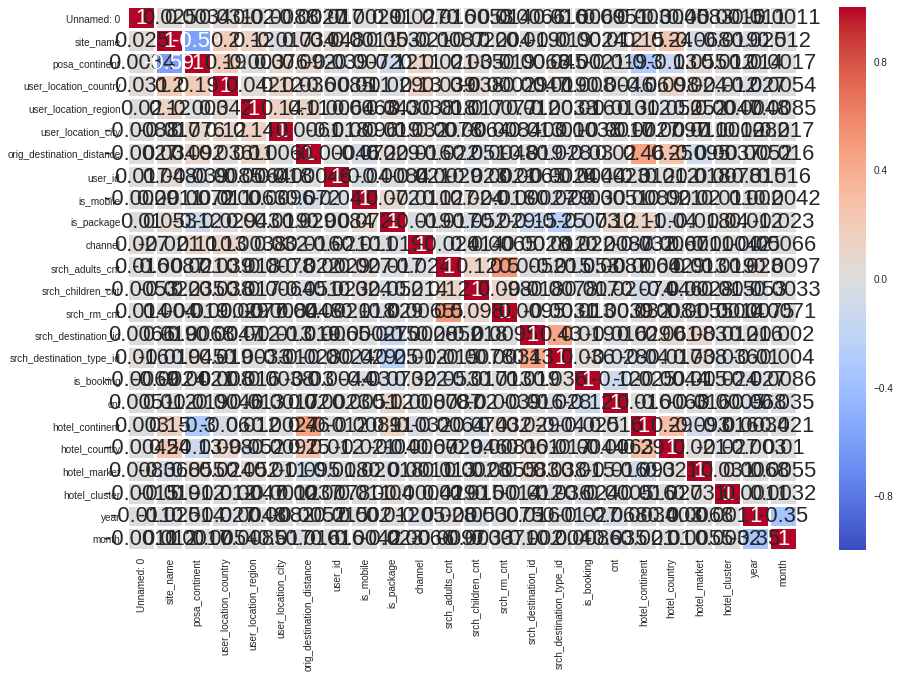

In [0]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 10)
sns.heatmap(t1.corr(),cmap='coolwarm',ax=ax,annot=True,linewidths=2)

In [0]:
# Generate useful features
def calc_fast_features(df):
    df["date_time"] = pd.to_datetime(df["date_time"])
    df["srch_ci"] = pd.to_datetime(df["srch_ci"], format='%Y-%m-%d', errors="coerce")
    df["srch_co"] = pd.to_datetime(df["srch_co"], format='%Y-%m-%d', errors="coerce")
    
    df["stay_dur"] = (df['srch_co'] - df['srch_ci']).astype('timedelta64[D]')
    df['no_of_days_bet_booking'] = (df['srch_ci'] - df['date_time']).astype('timedelta64[D]')
    
    props = {}
    for prop in ["month", "day", "hour", "minute", "dayofweek", "quarter"]:
        props[prop] = getattr(df["date_time"].dt, prop)
    
    carryover = [p for p in df.columns if p not in ["date_time", "srch_ci", "srch_co"]]
    for prop in carryover:
        props[prop] = df[prop]
    
    date_props = ["month", "day", "dayofweek", "quarter"]
    for prop in date_props:
        props["ci_{0}".format(prop)] = getattr(df["srch_ci"].dt, prop)
        props["co_{0}".format(prop)] = getattr(df["srch_co"].dt, prop)
        
    ret = pd.DataFrame(props)
    
    ret = ret.join(dest_small, on="srch_destination_id", how='left', rsuffix="dest")
    ret = ret.drop("srch_destination_id", axis=1)
    return ret

df = calc_fast_features(t1)
# For now, fill missing values with -1
#df.fillna(-1, inplace=True)

In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 202489 entries, 0 to 319953
Data columns (total 48 columns):
Unnamed: 0                   202489 non-null int64
channel                      202489 non-null int64
ci_day                       202140 non-null float64
ci_dayofweek                 202140 non-null float64
ci_month                     202140 non-null float64
ci_quarter                   202140 non-null float64
cnt                          202489 non-null int64
co_day                       202140 non-null float64
co_dayofweek                 202140 non-null float64
co_month                     202140 non-null float64
co_quarter                   202140 non-null float64
day                          202489 non-null int64
dayofweek                    202489 non-null int64
hotel_cluster                202489 non-null int64
hotel_continent              202489 non-null int64
hotel_country                202489 non-null int64
hotel_market                 202489 non-null int64
hour  

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


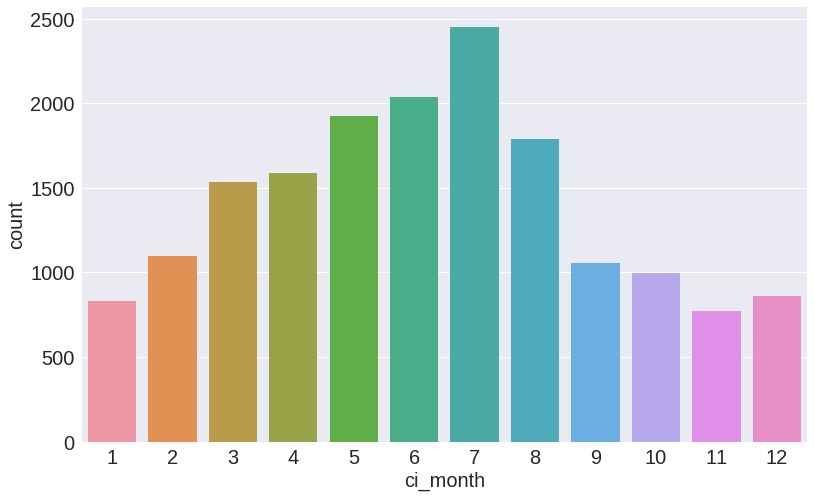

In [0]:
# Count the bookings in each month
fig, ax = plt.subplots()
fig.set_size_inches(13, 8)
sns.countplot('ci_month',data=df[df["is_booking"] == 1],order=list(range(1,13)),ax=ax)
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(20)
    

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


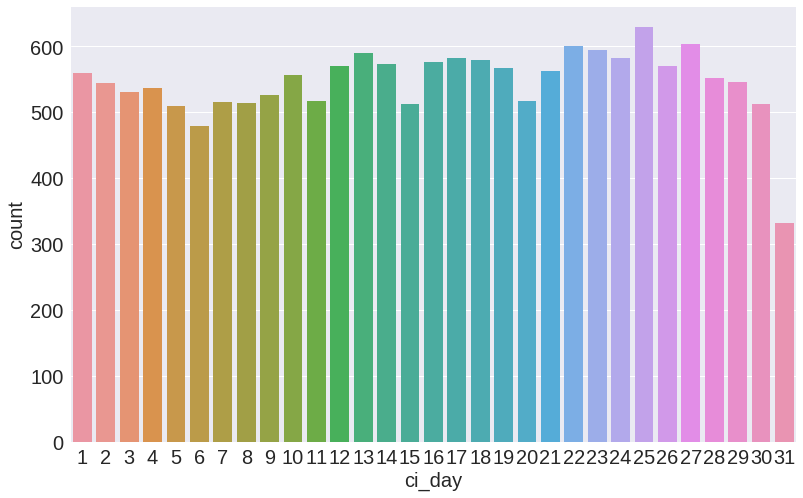

In [0]:
# Count the bookings as per the day
fig, ax = plt.subplots()
fig.set_size_inches(13, 8)
sns.countplot('ci_day',data=df[df["is_booking"] == 1],order=list(range(1,32)),ax=ax)
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(20)

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


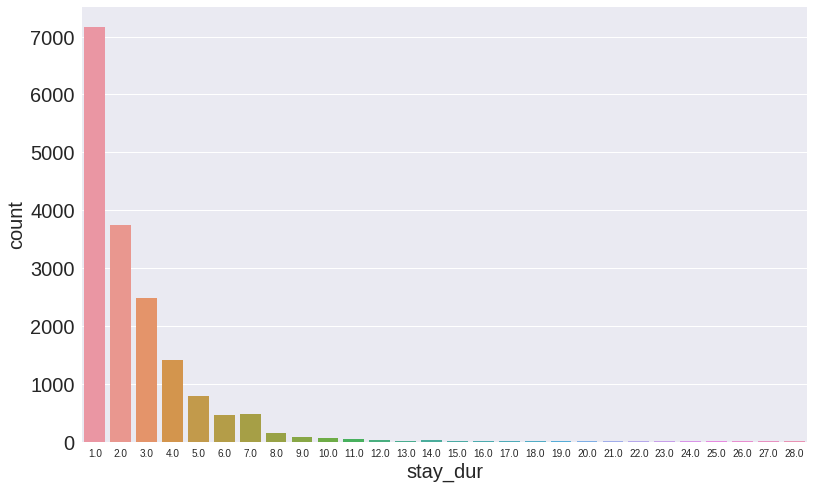

In [0]:
# Count the bookings as per the stay_duration
fig, ax = plt.subplots()
plt.locator_params(axis='x', nbins=10)
fig.set_size_inches(13, 8)
sns.countplot('stay_dur',data=df[df["is_booking"] == 1],ax=ax)
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_yticklabels()):
    item.set_fontsize(20)

In [0]:
# Check the percentage of Nan in dataset
total = train.isnull().sum().sort_values(ascending=False)
percent = (train.isnull().sum()/train['hotel_cluster'].count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data

,Total,Percent
orig_destination_distance,105923,0.358990
srch_co,373,0.001264
srch_ci,373,0.001264
date_time,0,0.000000
site_name,0,0.000000
posa_continent,0,0.000000
user_location_country,0,0.000000
user_location_region,0,0.000000
user_location_city,0,0.000000
user_id,0,0.000000


In [0]:


df['ci_day'] = df['ci_day'].fillna(25.0)
df['ci_month'] = df['ci_month'].fillna(7.0)
df['year'] = df['year'].fillna(2014.0)
df['stay_dur'] = df['stay_dur'].fillna(1.0)
df['no_of_days_bet_booking'] = df['no_of_days_bet_booking'].fillna(0.0)

## Model Selection